# Analyse des contenus Netflix
---
**Auteurs:** Ludovic Potvin & Louis Séranne

**Cours:** 8PRO408


# Mise en place
---
Importation de tous les prérequis pour l’analyse.

In [1]:
# LIEN DU DATASET : https://www.kaggle.com/datasets/shivamb/netflix-shows

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from plotly.subplots import make_subplots

df = pd.read_csv("netflix_titles.csv")

# 1. Exploration du dataset
---
## Information générale

In [2]:
# Affichage d'information general
print("Info\n-------")
print(df.info())
print("\nDescribe\n-------")
print(df.describe())
print("\nNombres de null\n-----")
print(df.isnull().sum())
print("\nNombres de duplicats: ", df.duplicated().sum())

Info
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None

Describe
-------
       release_year
count   8807.000000
mean    2014.180198
std        8.819312
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000

Nombres de null
-----
show_id      

## Observations

Les premiers affichages du code démontrent qu'il y a des données en erreur.

Les colonnes suivantes ont une ou plusieurs valeurs vides :
- director
- cast
- country
- date_added
- rating
- duration

### Nombre de director null par type

In [3]:
# Construction du data
null_count = df[df['director'].isnull()].groupby('type')['type'].count().to_frame('nulls')
total = df.groupby('type')['type'].count().to_frame('total')
result = pd.merge(total, null_count, left_index=True, right_index=True)
result['notnull'] = result['total'] - result['nulls']
result['null%'] = (result['nulls'] / result['total'] * 100)

# Affichage
print(result)

         total  nulls  notnull      null%
type                                     
Movie     6131    188     5943   3.066384
TV Show   2676   2446      230  91.405082


On peut remarquer que le nombre de null pour la colonne director est concentré dans le type TV Show.

# 2. Analyse de contenus
---
L'analyse de contenu vise à comparer les données entre elles et à voir les tendances.

## Film vs séries
Tout d'abord, voyons les proportions de film et de séries.

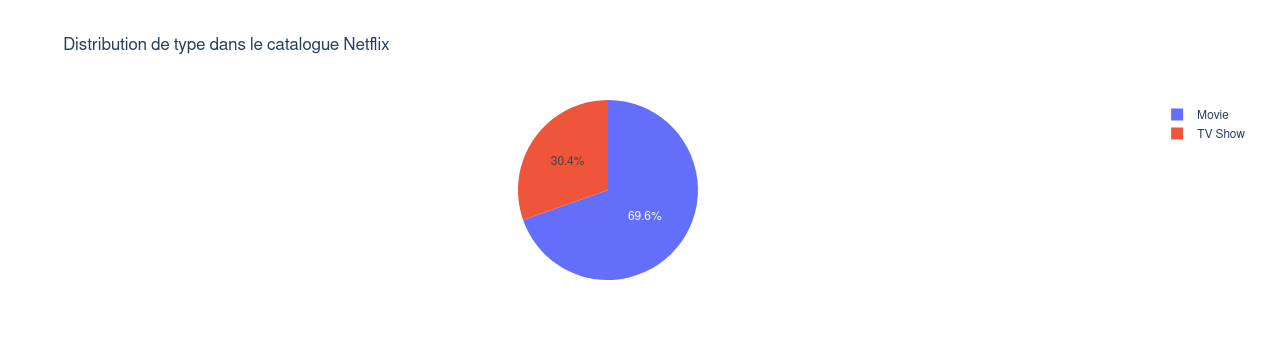

In [4]:
# Preparation de la donnees
data = df.groupby('type')['type'].count().reset_index(name='count')

fig = px.pie(
    data,
    names='type',
    values='count',
    title='Distribution de type dans le catalogue Netflix',
)
fig.show()

Avec ce graphique, il est facile de remarquer que le catalogue Netflix contient une proportion nettement plus importante de films que de série.

Cela s’explique par :
- Une production historique plus élevée de films dans l’industrie,
- La facilité de distribution de films anciens via les plateformes,
- Le coût généralement plus élevé de création de séries originales.

Même si Netflix investit massivement dans les séries depuis quelques années, la majorité du catalogue reste composée de films.

## Evolution du catalogue dans le temps

In [5]:
# Nombre de titres par type et année de sortie
data = (df
        .groupby(['release_year', 'type'])['show_id']
        .count()
        .reset_index(name='count'))

print(data)


     release_year     type  count
0            1925  TV Show      1
1            1942    Movie      2
2            1943    Movie      3
3            1944    Movie      3
4            1945    Movie      3
..            ...      ...    ...
114          2019  TV Show    397
115          2020    Movie    517
116          2020  TV Show    436
117          2021    Movie    277
118          2021  TV Show    315

[119 rows x 3 columns]


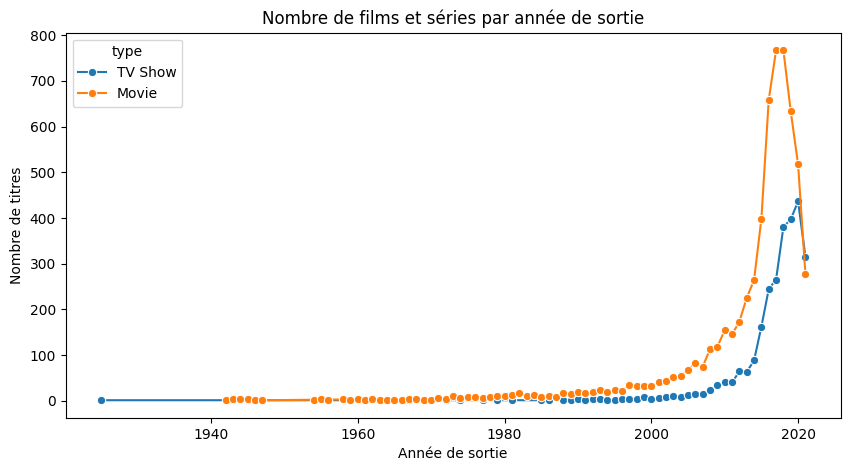

In [6]:
# Nombre de titres par type et année de sortie
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='release_year', y='count', hue='type', marker='o')
plt.title("Nombre de films et séries par année de sortie")
plt.xlabel("Année de sortie")
plt.ylabel("Nombre de titres")
plt.show()


On observe une croissance nette du nombre de titres à partir des années 2000, atteignant un pic vers 2017–2020.
Cela montre :
- Une modernisation progressive du catalogue,
- Un focus sur des productions plus récentes,
- Un faible volume de contenus très anciens (avant 1980), probablement dû aux droits de distribution complexes.

## Genres principaux

Nous analysons la colonne `listed_in` qui contient un ou plusieurs genres par titre.


In [7]:

# Exploser la colonne listed_in en une ligne par genre
genres_series = df['listed_in'].str.split(', ').explode()

genres_counts = genres_series.value_counts().reset_index()
genres_counts.columns = ['genre', 'count']
genres_counts.head()


,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869


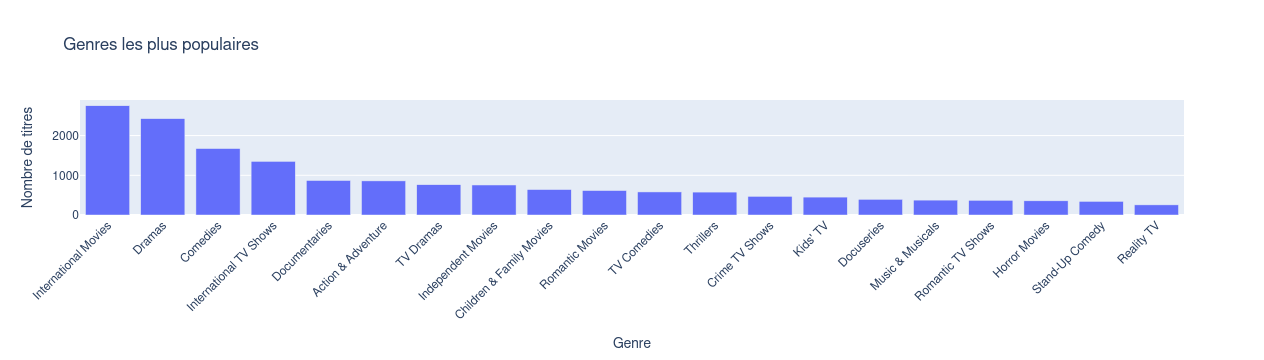

In [8]:
#Représentation par barre
fig = px.bar(
    genres_counts.head(20),
    x='genre', y='count',
    title='Genres les plus populaires',
    labels={'genre': 'Genre', 'count': 'Nombre de titres'}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Les genres dominants sont généralement :
International Movies
- Dramas
- Comedies
- Documentaries

Cela reflète :
- La stratégie internationale de Netflix, qui s’adresse à un public global
- Une forte production de drames, genre très répandu dans de nombreux pays
- Une présence significative de documentaires, domaine dans lequel Netflix investit fortement

La variété des genres témoigne d’un catalogue très diversifié pour attirer des audiences variées

## Année de sortie pas genre

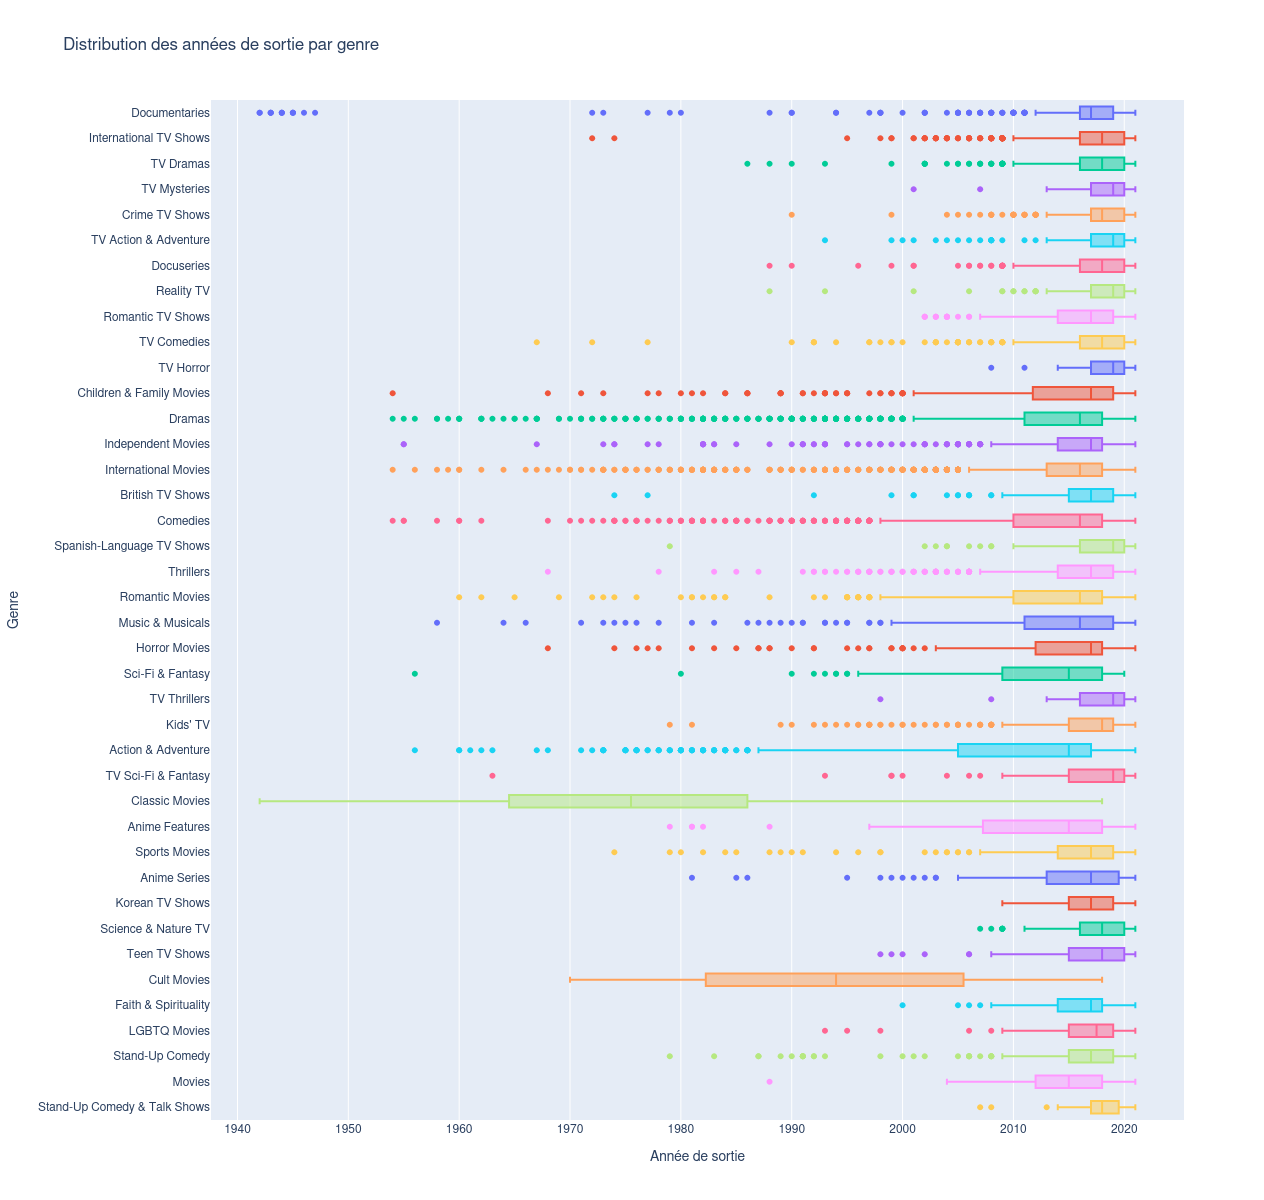

In [16]:
# Split genre in individual column
df_exploded = (
    df.assign(listed_in=df['listed_in'].str.split(', '))
      .explode('listed_in')
      .rename(columns={'listed_in': 'genre'})
)

# Find the tops
top = (
    df_exploded['genre'].value_counts()
    .nlargest(40)
    .index
)

df_top = df_exploded[df_exploded['genre'].isin(top)]

# 3. Create box plot
fig = px.box(
    df_top,
    x="release_year",
    y="genre",
    color="genre",
    title="Distribution des années de sortie par genre",
    orientation='h',
    hover_data = {'title'}
)

fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>"
)

# Clean axis labels
fig.update_layout(
    height=1200,
    xaxis_title="Année de sortie",
    yaxis_title="Genre",
    showlegend=False,
)

fig.show()

## Répartition géographique des contenus


In [10]:
countries_series = df['country'].replace('nan', np.nan).dropna().str.split(', ').explode()
country_counts = countries_series.value_counts().reset_index()
country_counts.columns = ['country', 'count']
country_counts.head()


,country,count
0,United States,3689
1,India,1046
2,United Kingdom,804
3,Canada,445
4,France,393


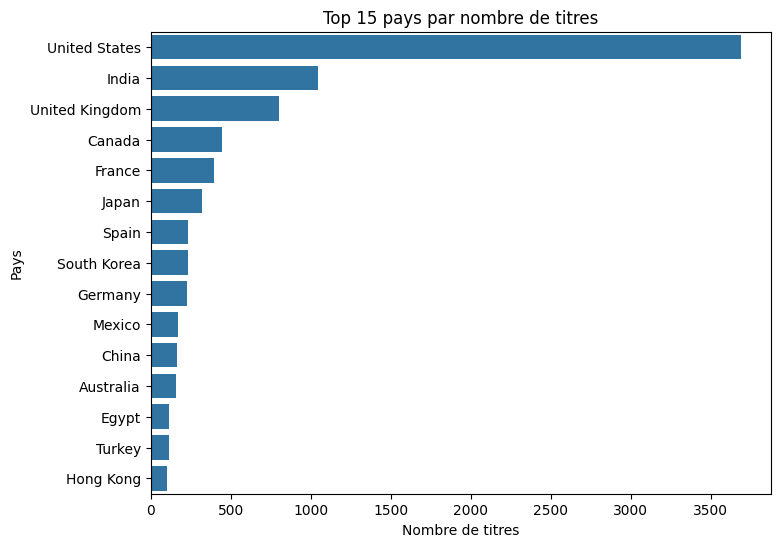

In [11]:
#Représentation par barre
plt.figure(figsize=(8, 6))
sns.barplot(data=country_counts.head(15), y='country', x='count')
plt.title("Top 15 pays par nombre de titres")
plt.xlabel("Nombre de titres")
plt.ylabel("Pays")
plt.show()


Les pays les plus représentés sont typiquement :
- États-Unis
- Inde, avec une forte production Bollywood
- Royaume-Uni
- Canada
- divers pays non anglophones (France, Japon, Corée du Sud…)

Ce résultat confirme :
- La domination de l’industrie américaine dans le cinéma et les séries
- La stratégie de Netflix visant à toucher des marchés internationaux
- L’importance croissante des productions indiennes et asiatiques

## Casting et réalisateurs


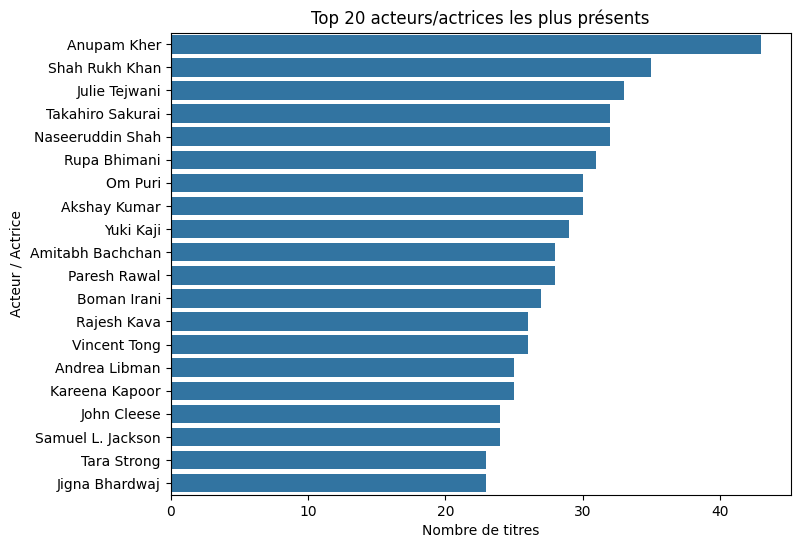

In [12]:
cast_series = df['cast'].replace('nan', np.nan).dropna().str.split(', ').explode()
cast_counts = cast_series.value_counts().reset_index()
cast_counts.columns = ['actor', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(data=cast_counts.head(20), y='actor', x='count')
plt.title("Top 20 acteurs/actrices les plus présents")
plt.xlabel("Nombre de titres")
plt.ylabel("Acteur / Actrice")
plt.show()


On note la présence majoritaire d’acteurs issus :
- Des productions américaines
- Des films indiens (Bollywood)

La concentration sur certains acteurs traduit soit une forte productivité, soit la présence de nombreuses productions issues d’un même pays ou studio.

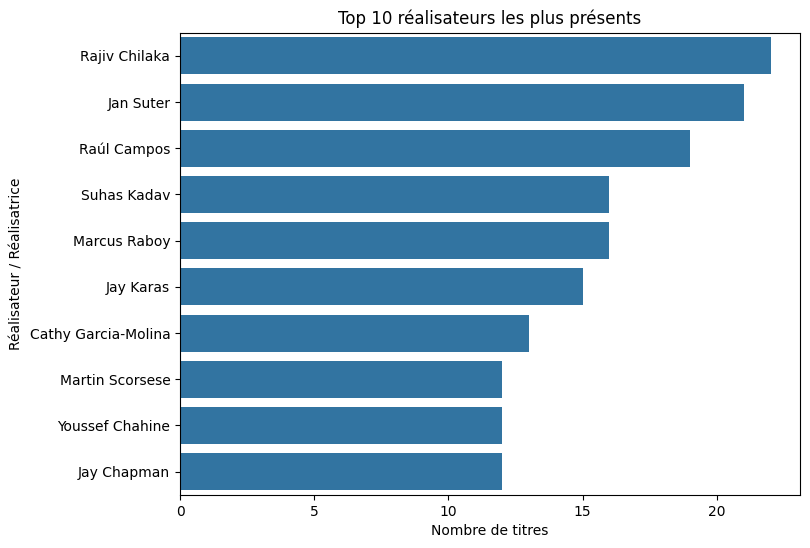

In [13]:
director_series = df['director'].replace('nan', np.nan).dropna().str.split(', ').explode()
director_counts = director_series.value_counts().reset_index()
director_counts.columns = ['director', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(data=director_counts.head(10), y='director', x='count')
plt.title("Top 10 réalisateurs les plus présents")
plt.xlabel("Nombre de titres")
plt.ylabel("Réalisateur / Réalisatrice")
plt.show()


Le nombre réduit de réalisateurs fréquemment représentés s’explique par :
- Le grand nombre de valeurs manquantes dans la colonne director
- La diversité des productions, qui distribue les réalisateurs sur un vaste ensemble
- L’absence de centralisation typique des plateformes de cinéma classiques

Cela rend difficile une analyse poussée des réalisateurs, mais confirme la pluralité des sources de contenus.

# 3. Analyse temporelle
---

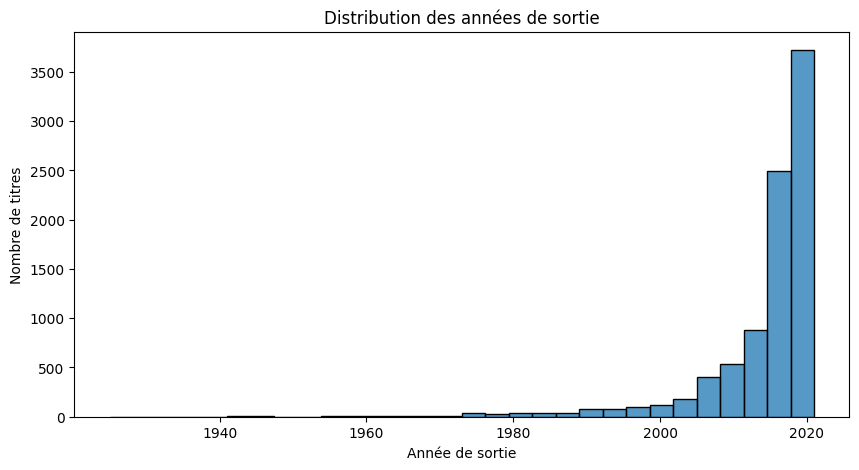

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='release_year', bins=30)
plt.title("Distribution des années de sortie")
plt.xlabel("Année de sortie")
plt.ylabel("Nombre de titres")
plt.show()


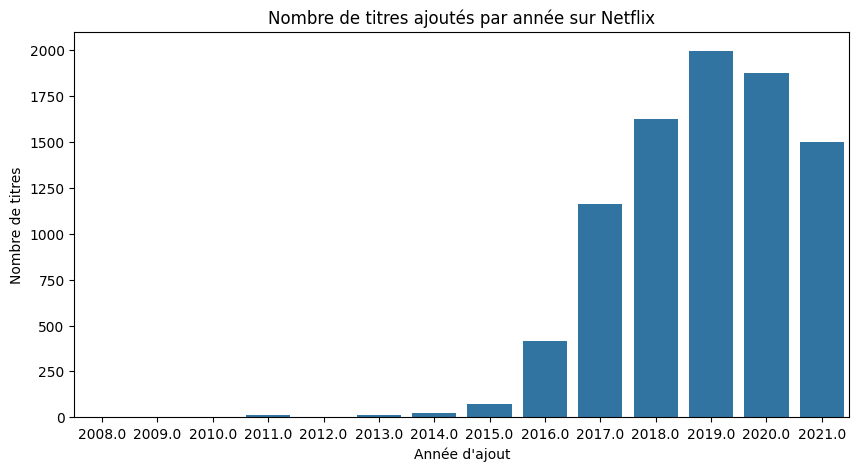

In [15]:
# Représentation par barre

df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
added_per_year = df['year_added'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=added_per_year.index, y=added_per_year.values)
plt.title("Nombre de titres ajoutés par année sur Netflix")
plt.xlabel("Année d'ajout")
plt.ylabel("Nombre de titres")
plt.show()

On observe une forte augmentation du nombre de contenus ajoutés à partir de 2015, correspondant à :
- L’expansion mondiale de Netflix
- L’arrivée massive de contenus originaux Netflix (Netflix Originals)
- Une stratégie de diversification du catalogue

Une baisse éventuelle après 2020 peut refléter :
- Des restrictions de droits
- Les effets de la pandémie sur la production mondiale

# Synthese
---
En conclusion, on a pu observer quelques informations intéressantes sur les données. Tout d'abord, on peut constater le gain en popularité de Netflix au fil du temps via le nombre de titres ajoutés à son catalogue. Il est aussi possible d'observer que certains genres ont gagné ou perdu en popularité au fil du temps. Une observation intéressante est de voir que les films jugés du genre classique se retrouvent plus proches des années 80 et 90 que de notre époque. Cependant, le nombre de films de notre époque est bien plus élevé. On pourrait peut-être en conclure que, comme il y a plus de films, il est plus difficile de devenir ce qu’on pourrait appeler un classique.

Notre dataset est cependant limité, car il nous manque les données après 2020 et surtout car il nous manque des données sur l’auditoire. Comme notre set de données est sur le catalogue, il est difficile de tirer des conclusions utiles pour mieux comprendre les habitudes des spectateurs.